In [15]:
import pandas as pd

import os
from sklearn.preprocessing import MinMaxScaler
from factor_analyzer.factor_analyzer import calculate_kmo
from factor_analyzer.factor_analyzer import FactorAnalyzer
import warnings
warnings.filterwarnings('ignore')
csv_list=[]
file =os.listdir()
for i in file:
    if ( i[-3:]=='csv'):
        csv_list.append(i)

In [16]:
csv_list[0][4:10]

'201712'

In [17]:
df = pd.read_csv('adm_202206.csv',encoding='euc-kr')
df.rename(columns={'price_2112':'price_2206'},inplace=True)
df.to_csv('adm_202206.csv',encoding='euc-kr',index=False)

In [18]:
def make_fa_score(csv_list):
    #파일을 하나씩 읽어오면서 진행
    for i in csv_list:
        print('###'+i+'파일실행')
        df = pd.read_csv(i,encoding='euc-kr')
        df_col=df[['시군구코드','price_'+i[6:10],'strc_'+i[6:10],'pop_'+i[6:10],'상가수','유동인구 평균','매출금액 평균','폐업수 합']]

        #스케일링
        scaler = MinMaxScaler()
        df_minmax_scaled = scaler.fit_transform(df_col.iloc[:,1:-1])
        df_minmax_scaled = pd.DataFrame(df_minmax_scaled,columns=df_col.iloc[:,1:-1].columns)
        #폐업수 cost 스케일링
        cob = (df_col[['폐업수 합']].max()-df_col[['폐업수 합']]) / ( df_col[['폐업수 합']].max()-df_col[['폐업수 합']].min() )

        #요인분석 데이터셋 생성
        data_set = pd.concat([df_minmax_scaled,cob],axis=1)
        
        #kmo 테스트
        kmo_all,kmo_model=calculate_kmo(data_set)

        print('kmo test value:' ,kmo_model)
        #요인분석
        
        fa = FactorAnalyzer(n_factors=7,rotation=None)
        fa.fit(data_set)

        ev,v=fa.get_eigenvalues()
        print('eignvalue 값:',ev)
        
        fa=FactorAnalyzer(n_factors=3,rotation='varimax')
        fa.fit(data_set)
        fa.get_factor_variance()
        
        #가중치 제작
        pd.DataFrame(fa.loadings_,columns=['fa1','fa2','fa3'])

        data_fa = pd.DataFrame(fa.loadings_,columns=['fa1','fa2','fa3'],index=data_set.columns)
        data_fa = data_fa.apply(lambda x:x*x)
        data_fa['sum'] = data_fa.sum(axis=1)
        data_fa['가중치'] = data_fa['sum']/data_fa['sum'].sum()
        data_fa.to_csv('행정동_가중치/'+i[6:10]+'_가중치.csv',encoding='euc-kr')
        
        #스코어 제작
        data_score = pd.DataFrame()
        
        for j in range(len(data_fa)):
            data_score=pd.concat([data_score,(data_set.iloc[:,j] * data_fa.iloc[j,4])],axis=1)
        data_score[i[6:10]+'_score']=data_score.sum(axis=1)
        
        #점수와 위치정보 결합
        a = df[df.columns[:5]]
        a = pd.concat([a,data_score],axis=1)
        
        #등급 산출
        bins=[]
        for k in reversed(range(1,11)):
            #bins.append(str(k)+'등급')
            bins.append(k)
        a[i[6:10]+'_절대등급'] = pd.cut(a[i[6:10]+'_score'],10,labels=bins)
        a[i[6:10]+'_상대등급'] = pd.qcut(a[i[6:10]+'_score'],10,labels=bins)
        
        #저장
        a.to_csv('행정동_요인분석/FA_'+i,encoding='euc-kr',index=False)

In [19]:
make_fa_score(csv_list)

###adm_201712.csv파일실행
kmo test value: 0.6500256599502184
eignvalue 값: [3.0714481  1.49308729 1.00784486 0.75768342 0.3007532  0.26050767
 0.10867546]
###adm_201806.csv파일실행
kmo test value: 0.6393539523665102
eignvalue 값: [3.07827034 1.48946942 1.02676431 0.74827082 0.30805818 0.26459399
 0.08457294]
###adm_201812.csv파일실행
kmo test value: 0.6500512902679778
eignvalue 값: [3.07067789 1.47162164 1.06480142 0.76135097 0.30109136 0.25076171
 0.079695  ]
###adm_201906.csv파일실행
kmo test value: 0.652241685913629
eignvalue 값: [3.03042865 1.43237938 1.08161748 0.80745446 0.29569776 0.26259287
 0.0898294 ]
###adm_201912.csv파일실행
kmo test value: 0.6538365637910002
eignvalue 값: [3.00046791 1.41240777 1.09827269 0.82852169 0.29025708 0.26546171
 0.10461114]
###adm_202006.csv파일실행
kmo test value: 0.6362926599830929
eignvalue 값: [2.96833106 1.40689078 1.11125621 0.86403103 0.28771485 0.27044304
 0.09133303]
###adm_202012.csv파일실행
kmo test value: 0.6407694167062497
eignvalue 값: [2.93607608 1.40754464 1.152102

KeyError: "['price_포함)_', 'strc_포함)_', 'pop_포함)_', '상가수', '유동인구 평균', '매출금액 평균', '폐업수 합'] not in index"

In [9]:
pd.read_csv('행정동_요인분석/FA_adm_202206.csv',encoding='euc-kr')

,WKT,시도,SIGUNGU_NM,ADM_DR_NM,시군구코드,price_2206,strc_2206,pop_2206,상가수,유동인구 평균,매출금액 평균,폐업수 합,2206_score,2206_절대등급,2206_상대등급
0,MULTIPOLYGON (((956144.676799997 1926791.06500...,경기도,수원시 장안구,파장동,41111560.0,0.009771,0.011538,0.018817,0.041476,0.021090,0.000143,0.141787,0.244622,9,8
1,"MULTIPOLYGON (((953430.847600002 1923415.439,9...",경기도,수원시 장안구,율천동,41111566.0,0.027868,0.009456,0.031651,0.055165,0.038475,0.000110,0.133842,0.296567,8,5
2,"MULTIPOLYGON (((954598.361899999 1923627.5777,...",경기도,수원시 장안구,정자1동,41111571.0,0.053337,0.016047,0.092171,0.026291,0.017380,0.000037,0.149121,0.354384,6,3
3,"MULTIPOLYGON (((955513.584699999 1922196.6204,...",경기도,수원시 장안구,정자2동,41111572.0,0.053337,0.016047,0.092171,0.045102,0.022071,0.000073,0.134453,0.363255,6,2
4,"MULTIPOLYGON (((958087.7235 1922275.02,958080....",경기도,수원시 장안구,영화동,41111580.0,0.048975,0.017733,0.022437,0.064412,0.034130,0.000113,0.122230,0.310030,7,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543,"MULTIPOLYGON (((1022538.551 1954630.9803,10225...",경기도,양평군,청운면,41830370.0,0.000151,0.016915,0.004176,0.008114,0.002663,0.000011,0.171122,0.203152,10,10
544,"MULTIPOLYGON (((1018405.9698 1946478.1428,1018...",경기도,양평군,양동면,41830380.0,0.000267,0.020037,0.005079,0.007615,0.005047,0.000038,0.173567,0.211650,10,9
545,"MULTIPOLYGON (((1011829.8535 1945324.8923,1011...",경기도,양평군,지평면,41830395.0,0.000522,0.029521,0.007648,0.009338,0.008473,0.000024,0.172956,0.228482,9,9
546,"MULTIPOLYGON (((1009252.2599 1953485.9096,1009...",경기도,양평군,용문면,41830400.0,0.000771,0.042328,0.019788,0.055210,0.019840,0.000059,0.142398,0.280394,8,6


# 병합

In [11]:
fa_list = os.listdir('행정동_요인분석/')

sum_fa_list = pd.DataFrame()
sum_fa_list= pd.read_csv('행정동_요인분석/'+fa_list[0],encoding='euc-kr').iloc[:,:5]
for i in fa_list:
    df=pd.read_csv('행정동_요인분석/'+i,encoding='euc-kr')
    sum_fa_list = pd.concat([sum_fa_list,df[df.columns[-3]]],axis=1)
    
sum_fa_list.to_csv('행정동_요인분석/행정동_sum_fa_list.csv',encoding='euc-kr',index=False)

In [ ]:
#등급포함한 데이터를 따로 추출
fa_list = os.listdir('행정동_요인분석/')

sum_fa_list = pd.DataFrame()
sum_fa_list= pd.read_csv('행정동_요인분석/'+fa_list[0],encoding='euc-kr').iloc[:,:5]
for i in fa_list:
    df=pd.read_csv('행정동_요인분석/'+i,encoding='euc-kr')
    sum_fa_list = pd.concat([sum_fa_list,df[df.columns[-3:]]],axis=1)
    
sum_fa_list.to_csv('행정동(등급포함)_sum_fa_list.csv',encoding='euc-kr',index=False)

# 한줄씩

In [5]:
csv_list=[]
file =os.listdir()
for i in file:
    if ( i[-3:]=='csv'):
        csv_list.append(i)

In [6]:
df = pd.read_csv(csv_list[2],encoding='euc-kr')

In [7]:
csv_list

['adm_201712.csv',
 'adm_201806.csv',
 'adm_201812.csv',
 'adm_201906.csv',
 'adm_201912.csv',
 'adm_202006.csv',
 'adm_202012.csv',
 'adm_202106.csv',
 'adm_202112.csv',
 'adm_202206.csv',
 '상권활성도_최종.csv']

In [8]:
df_col=df[['시군구코드','price_'+csv_list[2][6:10],'strc_'+csv_list[2][6:10],'pop_'+csv_list[2][6:10],'상가수','유동인구 평균','매출금액 평균','폐업수 합']]

In [9]:
df_col.head(2)

,시군구코드,price_1812,strc_1812,pop_1812,상가수,유동인구 평균,매출금액 평균,폐업수 합
0,41111560.0,268524.29,1673.0,17752.0,1102,5.068532e+06,2.947659e+10,98
1,41111566.0,770280.47,1365.0,29475.0,1447,7.254086e+06,2.697097e+10,125


In [10]:
import matplotlib.pyplot as plt

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/HANDotum.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df_minmax_scaled = scaler.fit_transform(df_col.iloc[:,1:-1])

In [12]:
df_minmax_scaled = pd.DataFrame(df_minmax_scaled,columns=df_col.iloc[:,1:-1].columns)

In [13]:
#cob = close of business
cob = (df_col[['폐업수 합']].max()-df_col[['폐업수 합']]) / ( df_col[['폐업수 합']].max()-df_col[['폐업수 합']].min() )


In [14]:
data_set = pd.concat([df_minmax_scaled,cob],axis=1)

In [15]:
data_set

,price_1812,strc_1812,pop_1812,상가수,유동인구 평균,매출금액 평균,폐업수 합
0,0.061817,0.151993,0.104666,0.198416,0.166285,0.035162,0.798768
1,0.179135,0.123894,0.173871,0.260533,0.239542,0.032172,0.743326
2,0.325638,0.251346,0.529782,0.153403,0.102817,0.011074,0.874743
3,0.325638,0.251346,0.529782,0.224883,0.140693,0.019681,0.780287
4,0.311451,0.235654,0.124820,0.315808,0.168644,0.031417,0.696099
...,...,...,...,...,...,...,...
543,0.000985,0.195603,0.021618,0.032409,0.020993,0.003633,0.985626
544,0.001846,0.229450,0.027102,0.030609,0.034118,0.009518,0.971253
545,0.003629,0.342578,0.039186,0.033489,0.048170,0.004429,0.973306
546,0.005395,0.492017,0.103562,0.225063,0.124823,0.015307,0.852156


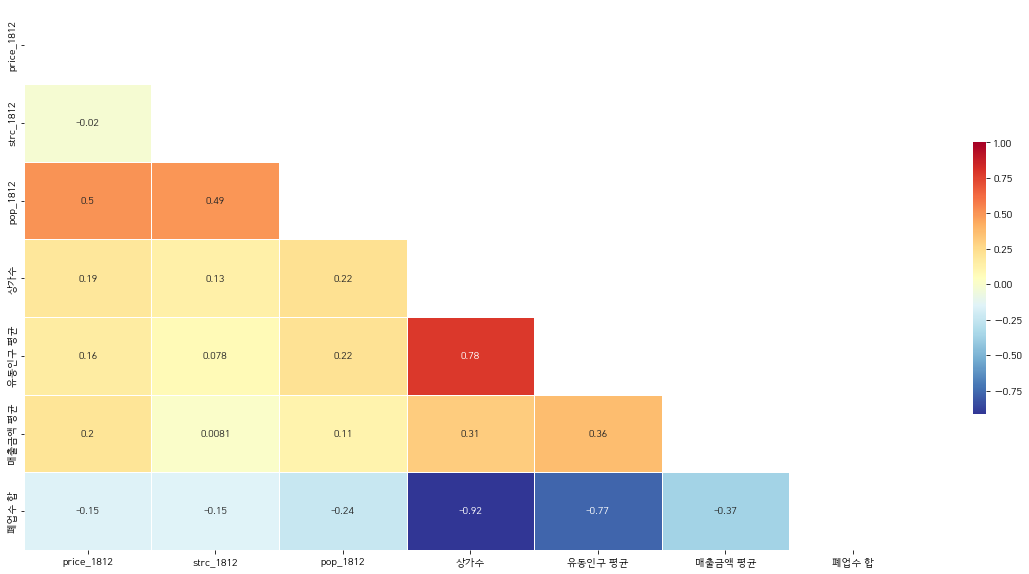

In [16]:
import numpy as np
import seaborn as sns
data_graph = data_set.corr()
# 그림 사이즈 지정
fig, ax = plt.subplots( figsize=(20,10) )
# 삼각형 마스크를 만든다(위 쪽 삼각형에 True, 아래 삼각형에 False)
mask = np.zeros_like(data_graph, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# 히트맵을 그린다
sns.heatmap(data_graph, 
            cmap = 'RdYlBu_r', 
            annot = True,   # 실제 값을 표시한다
            mask=mask,      # 표시하지 않을 마스크 부분을 지정한다
            linewidths=.5,  # 경계면 실선으로 구분하기
            cbar_kws={"shrink": .5},# 컬러바 크기 절반으로 줄이기
            vmax = 1   # 컬러바 범위 -1 ~ 1
           )  
plt.show()

### 요인분석

In [17]:
from factor_analyzer.factor_analyzer import FactorAnalyzer

In [18]:
fa = FactorAnalyzer(n_factors=7,rotation=None)
fa.fit(data_set)


ev,v=fa.get_eigenvalues()
ev
#기준 eigenvalue > 1

array([3.07067789, 1.47162164, 1.06480142, 0.76135097, 0.30109136,
       0.25076171, 0.079695  ])

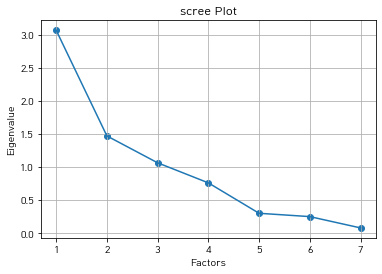

In [19]:
plt.scatter(range(1,data_set.shape[1]+1),ev)
plt.plot(range(1,data_set.shape[1]+1),ev)
plt.title('scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

#scree plot 상으로는 4개가 이상적으로 보이지만,  보조적인 수단이라는 점, 가중치 산출을 위한 요인분석이라는 점을 들어 2개 요인으로 축소
#요인분석을 개별적으로 추가 활용하기 위한 목적, (클러스터링 등) 이라면 4개 요인으로 늘려 보는 방향도 권장.

In [20]:
from factor_analyzer.factor_analyzer import calculate_kmo

kmo_all,kmo_model=calculate_kmo(data_set)

kmo_model

#수치 무난

0.6500512902679778

In [21]:
from factor_analyzer import FactorAnalyzer
fa=FactorAnalyzer(n_factors=3,rotation='varimax')
fa.fit(data_set)
fa.get_factor_variance()


(array([2.62612051, 1.21113692, 1.0923109 ]),
 array([0.37516007, 0.17301956, 0.15604441]),
 array([0.37516007, 0.54817963, 0.70422405]))

In [22]:
pd.DataFrame(fa.loadings_,columns=['fa1','fa2','fa3'])

,fa1,fa2,fa3
0,0.130376,0.987314,0.059702
1,0.047321,-0.072961,0.782194
2,0.148173,0.448035,0.664675
3,0.929465,0.048971,0.110802
4,0.821778,0.065825,0.069813
5,0.376335,0.151904,-0.007802
6,-0.950829,-0.022000,-0.133844


In [23]:
data_fa = pd.DataFrame(fa.loadings_,columns=['fa1','fa2','fa3'],index=data_set.columns)

#communality와 eigenvalue 계산을 위한 컬럼 생성
data_fa = data_fa.apply(lambda x:x*x)
data_fa['sum'] = data_fa.sum(axis=1)
data_fa['가중치'] = data_fa['sum']/data_fa['sum'].sum()

In [24]:
data_fa

,fa1,fa2,fa3,sum,가중치
price_1812,0.016998,0.974788,0.003564,0.995351,0.201914
strc_1812,0.002239,0.005323,0.611828,0.619391,0.125648
pop_1812,0.021955,0.200735,0.441792,0.664483,0.134795
상가수,0.863906,0.002398,0.012277,0.878581,0.178227
유동인구 평균,0.675319,0.004333,0.004874,0.684526,0.138861
매출금액 평균,0.141628,0.023075,0.000061,0.164764,0.033424
폐업수 합,0.904075,0.000484,0.017914,0.922474,0.187131


In [25]:
data_fa.loc[:,['가중치']]

,가중치
price_1812,0.201914
strc_1812,0.125648
pop_1812,0.134795
상가수,0.178227
유동인구 평균,0.138861
매출금액 평균,0.033424
폐업수 합,0.187131


In [26]:
data_fa.iloc[:,4]

price_1812    0.201914
strc_1812     0.125648
pop_1812      0.134795
상가수           0.178227
유동인구 평균       0.138861
매출금액 평균       0.033424
폐업수 합         0.187131
Name: 가중치, dtype: float64

In [27]:
data_score = pd.DataFrame()

In [28]:
for i in range(len(data_fa)):
    data_score=pd.concat([data_score,(data_set.iloc[:,i] * data_fa.iloc[i,4])],axis=1)

In [29]:
data_score['score']=data_score.sum(axis=1)

In [30]:
data_score['score'].rank(ascending=False)

0      357.0
1      255.0
2       90.0
3       88.0
4      192.0
       ...  
543    480.0
544    466.0
545    398.0
546    257.0
547    462.0
Name: score, Length: 548, dtype: float64

In [31]:
data_score

,price_1812,strc_1812,pop_1812,상가수,유동인구 평균,매출금액 평균,폐업수 합,score
0,0.012482,0.019098,0.014108,0.035363,0.023090,0.001175,0.149474,0.254791
1,0.036170,0.015567,0.023437,0.046434,0.033263,0.001075,0.139099,0.295046
2,0.065751,0.031581,0.071412,0.027341,0.014277,0.000370,0.163691,0.374424
3,0.065751,0.031581,0.071412,0.040080,0.019537,0.000658,0.146016,0.375035
4,0.062886,0.029609,0.016825,0.056286,0.023418,0.001050,0.130261,0.320336
...,...,...,...,...,...,...,...,...
543,0.000199,0.024577,0.002914,0.005776,0.002915,0.000121,0.184441,0.220944
544,0.000373,0.028830,0.003653,0.005455,0.004738,0.000318,0.181751,0.225118
545,0.000733,0.043044,0.005282,0.005969,0.006689,0.000148,0.182135,0.244000
546,0.001089,0.061821,0.013960,0.040112,0.017333,0.000512,0.159465,0.294291


In [32]:
a = df[df.columns[:5]]

In [33]:
a = pd.concat([a,data_score],axis=1)

In [34]:
bins=[]
for i in reversed(range(1,11)):
    bins.append(str(i)+'등급')

In [35]:
a['절대등급'] = pd.cut(a['score'],10,labels=bins)

In [36]:
a['상대등급'] = pd.qcut(a['score'],10,labels=bins)

In [37]:
a['절대등급'].value_counts()

9등급     148
10등급    104
8등급      97
7등급      85
6등급      59
5등급      35
4등급      14
3등급       5
1등급       1
2등급       0
Name: 절대등급, dtype: int64

In [38]:
a['상대등급'].value_counts()

10등급    55
9등급     55
8등급     55
6등급     55
5등급     55
3등급     55
2등급     55
1등급     55
7등급     54
4등급     54
Name: 상대등급, dtype: int64

In [39]:
a[a['상대등급']=='1등급']

,WKT,시도,SIGUNGU_NM,ADM_DR_NM,시군구코드,price_1812,strc_1812,pop_1812,상가수,유동인구 평균,매출금액 평균,폐업수 합,score,절대등급,상대등급
16,"MULTIPOLYGON (((958980.377099999 1917191.3721,...",경기도,수원시 권선구,권선1동,41113670.0,0.079781,0.029907,0.070285,0.076117,0.030021,0.001744,0.122192,0.410047,5등급,1등급
19,"MULTIPOLYGON (((958538.537699999 1916503.5458,...",경기도,수원시 권선구,권선2동,41113680.0,0.079781,0.029907,0.070285,0.046177,0.027085,0.001579,0.150243,0.405057,5등급,1등급
34,"MULTIPOLYGON (((960893.383299998 1918691.7686,...",경기도,수원시 영통구,매탄3동,41117530.0,0.068289,0.039617,0.077259,0.048648,0.048973,0.001226,0.129109,0.413121,5등급,1등급
44,"MULTIPOLYGON (((968234.9251 1937671.0145,96823...",경기도,성남시 수정구,신흥1동,41131510.0,0.120360,0.067094,0.028262,0.038861,0.008049,0.000476,0.158696,0.421799,5등급,1등급
45,"MULTIPOLYGON (((969099.490600002 1939816.0974,...",경기도,성남시 수정구,신흥2동,41131520.0,0.120360,0.067094,0.028262,0.022752,0.009364,0.000586,0.170224,0.418643,5등급,1등급
46,"MULTIPOLYGON (((968596.279199999 1937898.1939,...",경기도,성남시 수정구,신흥3동,41131530.0,0.120360,0.067094,0.028262,0.041941,0.006731,0.000492,0.159080,0.423961,5등급,1등급
47,MULTIPOLYGON (((966629.672299999 1939583.93520...,경기도,성남시 수정구,태평1동,41131540.0,0.072768,0.084816,0.048781,0.025223,0.013651,0.000378,0.167918,0.413535,5등급,1등급
48,"MULTIPOLYGON (((967937.0157 1939309.9137,96793...",경기도,성남시 수정구,태평2동,41131550.0,0.072768,0.084816,0.048781,0.021436,0.009137,0.000245,0.166765,0.403948,5등급,1등급
49,"MULTIPOLYGON (((967536.923900001 1938924.6388,...",경기도,성남시 수정구,태평3동,41131560.0,0.072768,0.084816,0.048781,0.024485,0.008456,0.000268,0.174066,0.413640,5등급,1등급
50,"MULTIPOLYGON (((968216.4027 1939488.6773,96821...",경기도,성남시 수정구,태평4동,41131561.0,0.072768,0.084816,0.048781,0.014922,0.006630,0.000506,0.179830,0.408253,5등급,1등급


### 파일 병합

In [60]:
fa_list = os.listdir('행정동_요인분석/')

In [61]:
sum_fa_list = pd.DataFrame()
sum_fa_list= pd.read_csv('행정동_요인분석/'+fa_list[0],encoding='euc-kr').iloc[:,:5]
for i in fa_list:
    df=pd.read_csv('행정동_요인분석/'+i,encoding='euc-kr')
    sum_fa_list = pd.concat([sum_fa_list,df[df.columns[-3]]],axis=1)    
sum_fa_list.to_csv('행정동_요인분석/sum_fa_list.csv',encoding='euc-kr',index=False)

In [58]:
sum_fa_list= pd.read_csv('행정동_요인분석/'+fa_list[0],encoding='euc-kr')

In [59]:
sum_fa_list

,WKT,시도,SIGUNGU_NM,ADM_DR_NM,시군구코드,price_1712,strc_1712,pop_1712,상가수,유동인구 평균,매출금액 평균,폐업수 합,1712_score,1712_절대등급,1712_상대등급
0,MULTIPOLYGON (((956144.676799997 1926791.06500...,경기도,수원시 장안구,파장동,41111560.0,0.009873,0.016994,0.023178,0.034952,0.025748,0.001443,0.129206,0.241393,9등급,7등급
1,"MULTIPOLYGON (((953430.847600002 1923415.439,9...",경기도,수원시 장안구,율천동,41111566.0,0.027148,0.013648,0.036171,0.042898,0.033446,0.001247,0.120900,0.275457,9등급,5등급
2,"MULTIPOLYGON (((954598.361899999 1923627.5777,...",경기도,수원시 장안구,정자1동,41111571.0,0.052349,0.028217,0.118722,0.026049,0.014945,0.000451,0.140742,0.381475,7등급,2등급
3,"MULTIPOLYGON (((955513.584699999 1922196.6204,...",경기도,수원시 장안구,정자2동,41111572.0,0.052349,0.028217,0.118722,0.038051,0.022414,0.000772,0.131974,0.392500,6등급,2등급
4,"MULTIPOLYGON (((958087.7235 1922275.02,958080....",경기도,수원시 장안구,영화동,41111580.0,0.047045,0.026232,0.027536,0.059780,0.023468,0.001208,0.107056,0.292325,8등급,5등급
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543,"MULTIPOLYGON (((1022538.551 1954630.9803,10225...",경기도,양평군,청운면,41830370.0,0.000170,0.020339,0.004740,0.005572,0.003342,0.000140,0.164276,0.198580,10등급,10등급
544,"MULTIPOLYGON (((1018405.9698 1946478.1428,1018...",경기도,양평군,양동면,41830380.0,0.000309,0.023562,0.005870,0.004979,0.004952,0.000396,0.165660,0.205728,10등급,9등급
545,"MULTIPOLYGON (((1011829.8535 1945324.8923,1011...",경기도,양평군,지평면,41830395.0,0.000593,0.035512,0.008412,0.005737,0.006346,0.000186,0.165660,0.222446,9등급,8등급
546,"MULTIPOLYGON (((1009252.2599 1953485.9096,1009...",경기도,양평군,용문면,41830400.0,0.000876,0.051083,0.021905,0.039073,0.017930,0.000654,0.145818,0.277339,8등급,5등급
